# 나와 닮은 연예인 찾기
## 1. 사진 모으기
- 내 사진과 연예인 사진을 모아 저장한다.

## 2. 얼굴 영역 자르기
- 이미지에서 얼굴 영역을 자른다.
- `Image.fromarray`를 통해서 PIL Image로 변환한 뒤 저장하여 나중에 시각화에 사용한다.

In [1]:
import face_recognition
import os
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print(len(file_list))   # 이미지 파일 개수

402


In [2]:
# 이미지 파일에서 얼굴 영역을 가져오는 함수
def get_gropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

In [3]:
# 얼굴 영역을 잘라서 이미지로 저장하는 함수
def save_cropped_face(dir_path):
    file_list = os.listdir(dir_path)
    
    for file in file_list:
        try:
            img_path = os.path.join(dir_path, file)
            face = get_gropped_face(img_path)
            pillow_image = Image.fromarray(face)
            path_to_save = os.path.join(save_path, file)
            pillow_image.save(path_to_save)
        except:
            os.remove(img_path)   # 얼굴 인식이 안되는 사진은 삭제
            print(file, "was removed")
    
    print('Cropped images are saved')

save_path = os.getenv('HOME')+'/aiffel/face_embedding/images_cropped'
save_cropped_face(dir_path)

태연5.jpg was removed
고은채3.jpg was removed
Cropped images are saved


## 3. 얼굴 영역의 임베딩 추출하기
- 이미지의 얼굴 영역으로부터 얼굴 임베딩 벡터를 구한다.
- 디렉토리 안에 있는 모든 얼굴 이미지의 임베딩 딕셔너리를 구한다.

In [4]:
# 얼굴 영역으로부터 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [5]:
# 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_gropped_face(img_path)      # 얼굴 영역을 구하는 함수
        embedding = get_face_embedding(face)   # 얼굴 임베딩 벡터를 구하는 함수
        if len(embedding) > 0:  # 얼굴영역 face가 제대로 detect되지 않으면 len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
    
    print("Embedding dictionary was made")
    return embedding_dict

# 내 사진의 임베딩 딕셔너리 출력
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['고은채1']

Embedding dictionary was made


array([-0.12784436,  0.10448948,  0.00994151, -0.11465763, -0.14201827,
       -0.0666955 , -0.07937627, -0.07665567,  0.14679766, -0.11085141,
        0.2065116 , -0.11440607, -0.21771631, -0.09120598, -0.08811358,
        0.25951171, -0.2395359 , -0.13590126, -0.00925686,  0.00656124,
        0.15065549,  0.01079155, -0.05236992,  0.07051725, -0.11669068,
       -0.31546485, -0.05581702, -0.06806715, -0.0489037 , -0.09101848,
       -0.0101376 ,  0.0581856 , -0.17303206, -0.02759539,  0.02669946,
        0.08334157,  0.00140176, -0.10138684,  0.15911688, -0.00163643,
       -0.28361756, -0.02073763,  0.11070047,  0.18708329,  0.17379852,
       -0.01911343,  0.0057533 , -0.15386668,  0.15663283, -0.16263032,
       -0.04790429,  0.14580764,  0.05357089,  0.07113975,  0.01887064,
       -0.12331574,  0.06889544,  0.16526967, -0.13515526, -0.03613933,
        0.10599857, -0.1019676 , -0.01170274, -0.10200847,  0.21783955,
        0.04580704, -0.11585851, -0.17724352,  0.15315324, -0.10

## 4. 연예인들과 거리 비교하기
- 이미지들 간의 임베딩 벡터 거리를 구한다.
- 거리를 비교하여 나와 가장 가까운 연예인 순위를 출력한다

In [6]:
import numpy as np

# 두 이미지 사이의 임베딩 벡터 거리를 구하는 함수
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

# 내 사진들끼리의 얼굴 임베딩 벡터 거리 계산
print(get_distance('고은채1', '고은채2'))

0.3553166411438206


In [7]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [25]:
import pandas as pd

# 거리가 가장 가까운 순으로 출력해주는 함수
def get_nearest_face(name, top=6):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank, name, dist = [], [], []
    idx = 1
    
    for i in range(top+1):
        if i == 0 :   # 첫 번째로 나오는 이름은 자기 자신이므로 제외
            continue
        elif sorted_faces[i][0].startswith('고은채'):   # 나의 다른 사진도 제외
            continue
        else:
            rank.append(idx)
            name.append(sorted_faces[i][0])
            dist.append(sort_key_func(sorted_faces[i][0]))
            idx += 1
    
    data = {'Rank': rank, 'Name': name, 'Distance': dist}
    return pd.DataFrame(data)

In [27]:
# 나와 가장 닮은 사람은 누굴까요?
get_nearest_face('고은채1')

,Rank,Name,Distance
0,1,박소담3,0.332303
1,2,박소담4,0.342362
2,3,박소담,0.360422
3,4,박보영,0.361169
4,5,박보영4,0.367871


In [28]:
# 다른 사진으로 테스트
get_nearest_face('고은채2')

,Rank,Name,Distance
0,1,박보영4,0.355975
1,2,박소담4,0.359376
2,3,박보영3,0.362189
3,4,박소담,0.366569
4,5,김고은5,0.372636


## 5. 시각화
### 5-1. 유사도 점수 계산

In [71]:
df_1 = get_nearest_face('고은채1')
df_1['Similarity'] = 1 - df_1['Distance']   # 1에서 거리를 뺀 유사도
df_1['Score'] = (df_1['Similarity'] * 100).round().astype(int)  # 유사도에 100을 곱해 반올림한 점수
df_1

,Rank,Name,Distance,Similarity,Score
0,1,박소담3,0.332303,0.667697,67
1,2,박소담4,0.342362,0.657638,66
2,3,박소담,0.360422,0.639578,64
3,4,박보영,0.361169,0.638831,64
4,5,박보영4,0.367871,0.632129,63


In [72]:
df_2 = get_nearest_face('고은채2')
df_2['Similarity'] = 1 - df_2['Distance']
df_2['Score'] = (df_2['Similarity'] * 100).round().astype(int)
df_2

,Rank,Name,Distance,Similarity,Score
0,1,박보영4,0.355975,0.644025,64
1,2,박소담4,0.359376,0.640624,64
2,3,박보영3,0.362189,0.637811,64
3,4,박소담,0.366569,0.633431,63
4,5,김고은5,0.372636,0.627364,63


### 5-2. Top 5 이미지와 점수 출력

In [83]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_nearest_image(name):
    # 데이터프레임으로 점수 계산
    df = get_nearest_face(name)
    df['Similarity'] = 1 - df['Distance']
    df['Score'] = (df['Similarity'] * 100).round().astype(int)
    
    # 이미지 출력
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 1, 6
    i = 1
    
    name_list = [name] + list(df['Name'])
    score_list = ['My Photo'] + list(df['Score'])
    
    for name in name_list:
        dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images_cropped'
        img_path = os.path.join(dir_path, name + '.jpg')
        img = mpimg.imread(img_path)
        ax = fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        ax.set_title(score_list[i-1])
        i += 1

    plt.show()

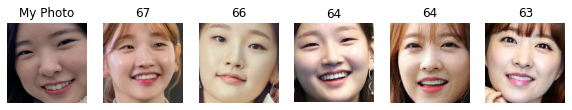

In [84]:
get_nearest_image('고은채1')

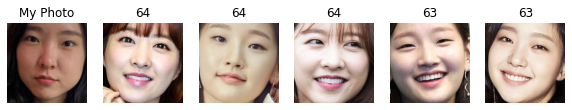

In [85]:
get_nearest_image('고은채2')

***
# 프로젝트 정리
1. **데이터 수집 및 전처리**: 이미지를 수집하고 사람 이름으로 라벨링하는 데 시간이 오래 걸렸다. 그리고 얼굴 인식이 안되는 사진도 꽤 많았다. 특히 내 사진을 고를 때 얼굴이 가깝게 나온 셀카는 인식이 되지 않아서 멀리서 찍힌 사진으로 교체했다. 그리고 얼굴 인식이 안 되는 사진을 넣으면 전처리 단계에서 오류가 발생하기 때문에 예외 처리를 통해 해당 파일들을 삭제했다.
2. **임베딩 벡터 거리 계산**: 나의 다른 표정도 유사한 얼굴로 인식하는지 테스트하기 위해 일부러 웃는 사진과 무표정인 사진을 골라보았다. 두 이미지의 임베딩 벡터 거리를 구한 결과 0.3553 정도로 비교적 가깝게 나왔다. 비슷한 표정의 사진 두 장으로 테스트해보니 0.3 이하로 더 가깝게 나왔다.
3. **닮은 연예인 찾기**: 역시 웃는 사진과 무표정인 사진으로 모두 테스트해봤는데, 신기하게도 Top 5 결과가 비슷했다. 박소담과 박보영이 압도적으로 많았고, 심지어 내 사진 두 장의 거리인 0.3553보다 더 가깝게 나온 것도 있었다. 이 정도면 AI가 인정한 닮은 꼴이라고 할 수 있겠다.
4. **시각화**: 소수로 표현된 거리는 직관적이지 않기 때문에 100점 만점의 점수로 환산해보았다. 1에서 거리를 뺀 유사도에 100을 곱해 점수를 계산했다. 그리고 Top 5 이미지에 점수를 표시해 출력했다. 각 사람의 이름도 같이 출력하고 싶었으나 한글 폰트가 깨지는 문제를 해결하지 못했다. 어쨌든 사진을 모아놓고 보니 더 실감이 났다. 좀 더 다양한 결과를 보고 싶다면 동일 인물은 제일 높은 순위 하나만 기록하고 나머지는 스킵해서 서로 다른 5명을 보여주는 것도 좋을 것 같다.